In [1]:
from radmc3dPy.image import readImage, plotImage, makeImage
from matplotlib import cm
from matplotlib import pyplot as plt
import os
import numpy as np

from astropy import constants as c

au = c.au.cgs.value
pc = c.pc.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value
Grav = c.G.cgs.value
m_p = c.m_p.cgs.value


def logistic(a, r, r0, dr):
    return np.radians(a / (1.0 + np.exp((r - r0) / (0.1 * dr))))


def grid_refine_inner_edge(x_orig, nlev, nspan):
    x = x_orig.copy()
    rev = x[0] > x[1]
    for ilev in range(nlev):
        x_new = 0.5 * (x[1:nspan + 1] + x[:nspan])
        x_ref = np.hstack((x, x_new))
        x_ref.sort()
        x = x_ref
        if rev:
            x = x[::-1]
    return x


def warp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(phi) - y * np.sin(phi) * np.cos(theta) + z * np.sin(phi) * np.sin(theta)
    yprime = x * np.sin(phi) + y * np.cos(phi) * np.cos(theta) - z * np.sin(theta) * np.cos(phi)
    zprime = y * np.sin(theta) + z * np.cos(theta)
    return xprime, yprime, zprime


def unwarp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(phi) + y * np.sin(phi)
    yprime = -x * np.sin(phi) * np.cos(theta) + y * np.cos(phi) * np.cos(theta) + z * np.sin(theta)
    zprime = x * np.sin(phi) * np.sin(theta) - y * np.sin(theta) * np.cos(phi) + z * np.cos(theta)
    return xprime, yprime, zprime

In [2]:
# Monte Carlo parameters
#
nphot_therm = 1000000
nphot_scat = 1000000

In [3]:
# Grid parameters
#
n_r = 200
n_theta = 128
n_phi = 128
r_in = 0.5 * au
r_out = 100 * au
thetaup = 0.1       # Theta grid starting point (0=pole, but singular, so choose >0)

In [4]:
# inner edge grid refinement
nlev_rin = 8
nspan_rin = 3

In [5]:
# Disk parameters
#
sigma_0 = 1e1           # Gas surface density at 1 au [g / cm^2]
d2g = 0.01              # dust-to-gas ratio
gamma_gas = 1.0         # power-law exponent of the surface density
hor_0 = 0.05            # h/r at 1 au
hor_exp = 0.1           # flaring exponent

In [6]:
# Star parameters
#
M_star = 2.4 * M_sun
R_star = 2.4 * R_sun
T_star = 1e4
star_coord = np.array([0., 0., 0.])

In [7]:
# Make the coordinates
#
ri = np.geomspace(r_in, r_out, n_r + 1)
ri = grid_refine_inner_edge(ri, nlev_rin, nspan_rin)   # Refinement at inner edge
thetai = np.linspace(thetaup, np.pi - thetaup, n_theta + 1)
phii = np.linspace(0.0, 2.0 * np.pi, n_phi + 1)
rc = 0.5 * (ri[:-1] + ri[1:])
thetac = 0.5 * (thetai[:-1] + thetai[1:])
phic = 0.5 * (phii[:-1] + phii[1:])
n_r = len(rc)     # Recompute nr, because of refinement at inner edge

In [8]:
# Make the full mesh
#
RC, THETAC, PHIC = np.meshgrid(rc, thetac, phic, indexing='ij')
XC = RC * np.sin(THETAC) * np.cos(PHIC)
YC = RC * np.sin(THETAC) * np.sin(PHIC)
ZC = RC * np.cos(THETAC)

In [9]:
# Warp the coordinates
#
warp = 60.
twist = 60.

warp_array = logistic(warp, rc, 40 * au, 30 * au)  # Specify the r0 and dr in AU
twist_array = logistic(twist, rc, 40 * au, 30 * au)

XW, YW, ZW = unwarp_coordinates(
    XC, YC, ZC,
    warp_array[:, None, None],
    twist_array[:, None, None])

RW = np.sqrt(XW**2 + YW**2 + ZW**2)
THETAW = np.pi / 2.0 - np.arctan2(ZW, np.sqrt(XW**2 + YW**2))
PHIW = np.arctan2(YW, XW) + np.pi

In [10]:
# Make the dust density model
#
sig_g = sigma_0 * (RW / au)**-gamma_gas
H = hor_0 * (RW / au)**hor_exp * RW
rho_g = (sig_g / (np.sqrt(2. * np.pi) * H)) * np.exp(-(ZW**2 / H**2) / 2.0)
rho_d = d2g * rho_g

In [11]:
# Make the velocity model
# TODO: this one has right dimensions, but
# wasn't yet really computed
vr = np.zeros_like(RW)
vtheta = np.zeros_like(RW)
vphi = np.sqrt(Grav * M_star / RW)

vturb = 0.001 * vphi

In [12]:
# Write the wavelength_micron.inp file
#
lam1 = 0.1e0
lam2 = 7.0e0
lam3 = 25.e0
lam4 = 1.0e4
n12 = 20
n23 = 100
n34 = 30
lam12 = np.geomspace(lam1, lam2, n12, endpoint=False)
lam23 = np.geomspace(lam2, lam3, n23, endpoint=False)
lam34 = np.geomspace(lam3, lam4, n34, endpoint=True)
lam = np.concatenate([lam12, lam23, lam34])
nlam = lam.size

In [13]:
# Write the wavelength file
#
with open('wavelength_micron.inp', 'w+') as f:
    f.write('%d\n' % (nlam))
    for value in lam:
        f.write('%13.6e\n' % (value))

In [14]:
# Write the stars.inp file
#
with open('stars.inp', 'w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n' % (nlam))
    f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n' % (R_star, M_star, *star_coord))
    for value in lam:
        f.write('%13.6e\n' % (value))
    f.write('\n%13.6e\n' % (-T_star))

In [15]:
# Write the grid file
#
with open('amr_grid.inp', 'w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 1\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n' % (n_r, n_theta, n_phi))  # Size of grid
    for value in ri:
        f.write('%13.6e\n' % (value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%13.6e\n' % (value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%13.6e\n' % (value))      # Z coordinates (cell walls)

In [16]:
# Write the density file
#
with open('dust_density.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    f.write('1\n')                       # Nr of dust species
    data = rho_d.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [17]:
# Dust opacity control file
#
with open('dustopac.inp', 'w+') as f:
    f.write('2               Format number of this file\n')
    f.write('1               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('silicate        Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')

In [18]:
# Write the molecule number density file.
#
CO_abundance = 1e-4
fact_CO = CO_abundance / (2.3 * m_p)
nco = rho_g * fact_CO
with open('numberdens_co.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = nco.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [19]:
# Write the gas velocity field
#
with open('gas_velocity.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    for iphi in range(n_phi):
        for itheta in range(n_theta):
            for ir in range(n_r):
                f.write('%13.6e %13.6e %13.6e\n' % (vr[ir, itheta, iphi], vtheta[ir, itheta, iphi], vphi[ir, itheta, iphi]))

In [20]:
# Write the microturbulence file
#
with open('microturbulence.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = vturb.ravel(order='F')        # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [21]:
# Write the lines.inp control file
#
with open('lines.inp', 'w') as f:
    f.write('1\n')
    f.write('1\n')
    f.write('co    leiden    0    0\n')

In [22]:
# Write the radmc3d.inp control file
#
with open('radmc3d.inp', 'w+') as f:
    f.write('nphot = %d\n' % (nphot_therm))
    f.write('nphot_scat = %d\n' % (nphot_scat))
    f.write('scattering_mode_max = 1\n')
    f.write('iranfreqmode = 1\n')
    f.write('tgas_eq_tdust = 1\n')

In [23]:
# Run thermal monte carlo
os.system('radmc3d mctherm setthreads 8')

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

0

In [24]:
# Now let's make a set of channel maps
#
vkms = 0
# command = 'radmc3d image imolspec 1 iline 2 linenlam 20 widthkms 10. theta 45 npix 200'
command = 'radmc3d image imolspec 1 iline 2 vkms {} incl 45 phi 45 npix 200 setthreads 4'.format(vkms)
os.system(command)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

0

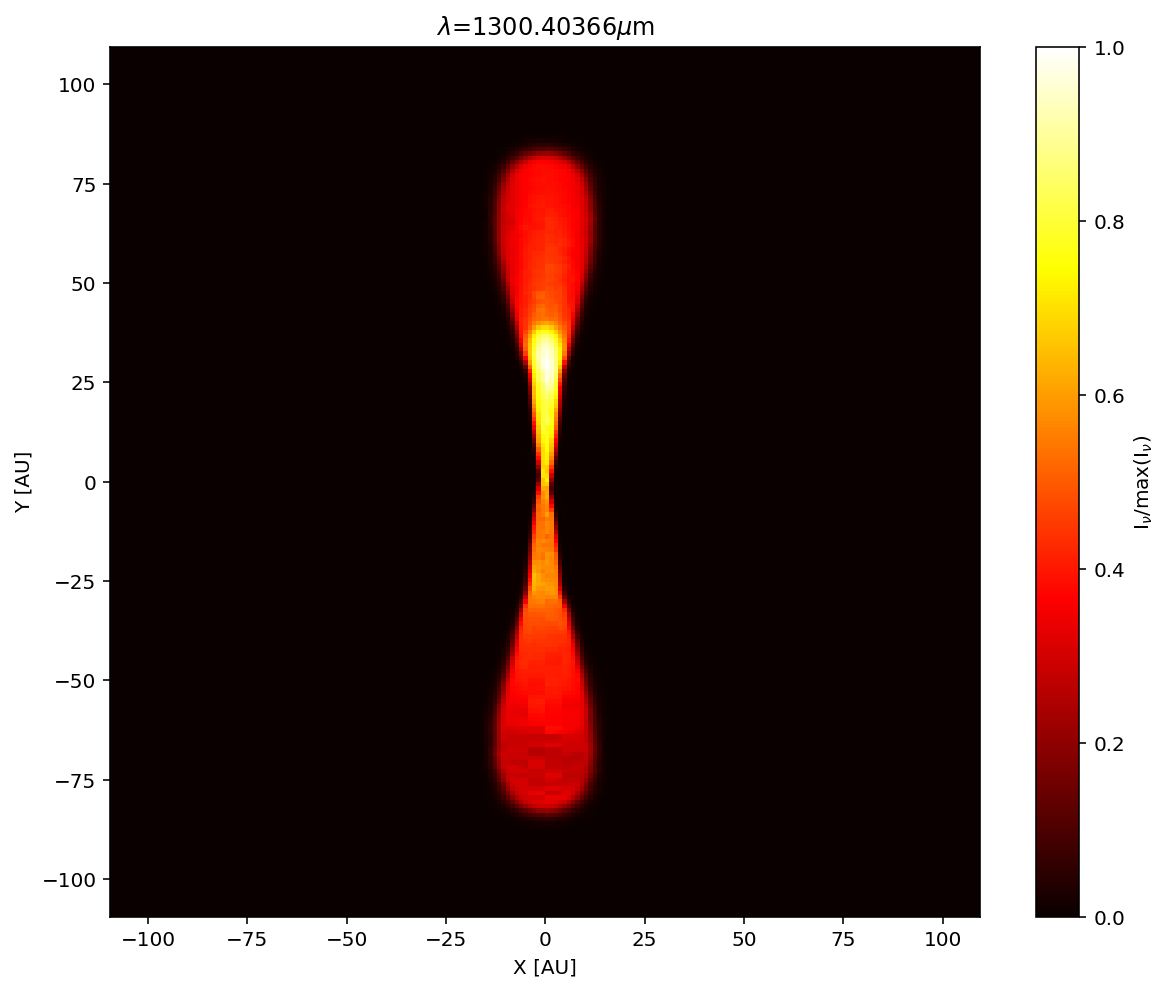

{'implot': <matplotlib.image.AxesImage at 0x116e1c910>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x117118670>}

In [25]:
# Read the image
#
im = readImage()
# plotImage(im,ifreq=18,au=True,cmap=cm.hot)
f, ax = plt.subplots(figsize=(10, 8))
plotImage(im, au=True, cmap=cm.hot, ax=ax)

In [26]:

dpc = 140.     # Distance in parsec (for conversion to Jy/pixel in 1.3 mm map)
incl = 45.
phi = 45.

In [27]:
# Make and plot image of full disk at 1.3 mm: thermal dust emission
#
makeImage(npix=400, incl=incl, phi=phi, wav=1.3e3, sizeau=200)  # , setthreads=4)   # This calls radmc3d

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

0

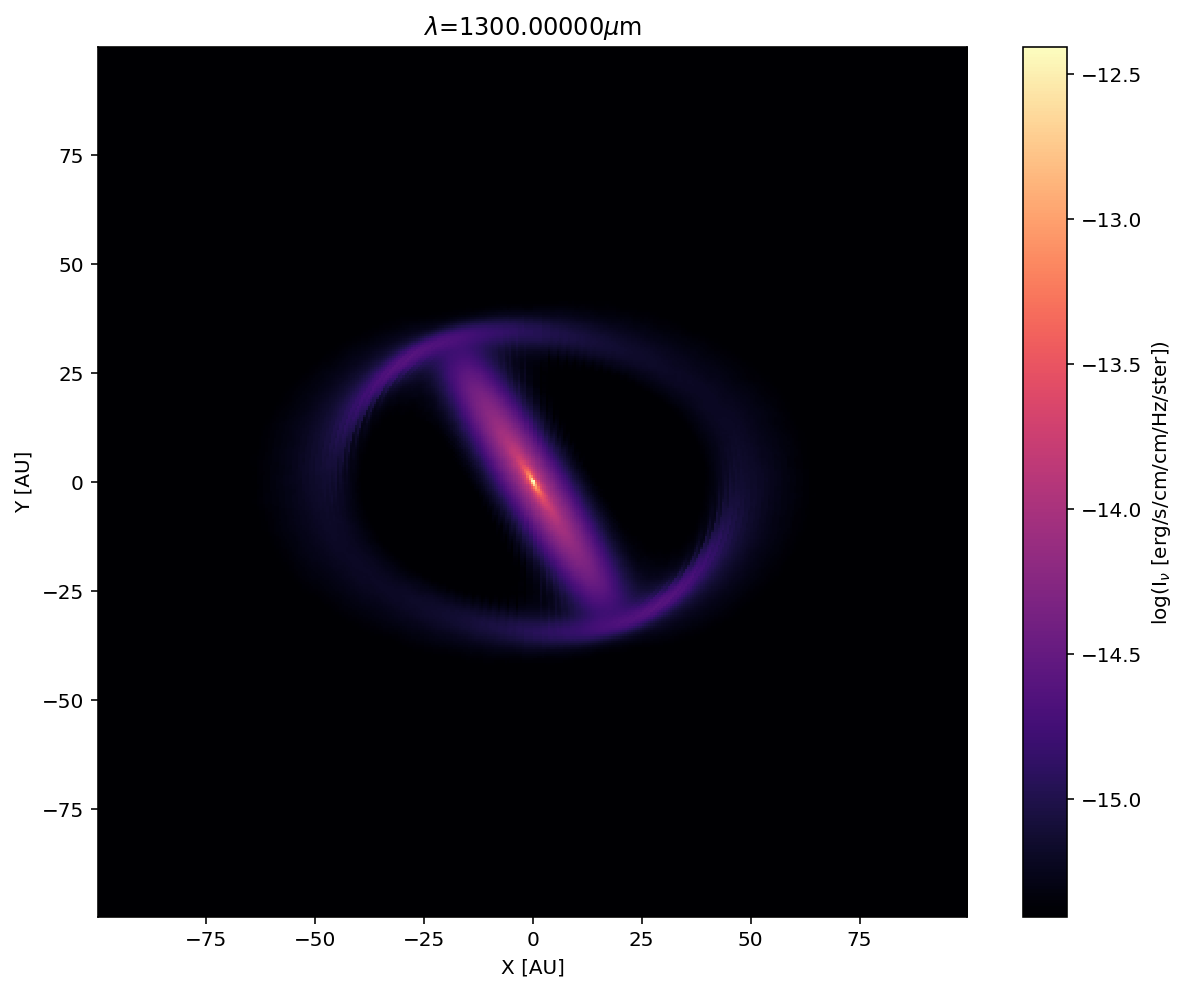

{'implot': <matplotlib.image.AxesImage at 0x11754f8b0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x11757f5e0>}

In [28]:
im_mm = readImage()
f, ax = plt.subplots(figsize=(10, 8))
plotImage(im_mm, au=True, log=True, maxlog=3, bunit='inu', dpc=dpc, cmap='magma', ax=ax)